<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllCF_Norm_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import  drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/crowdFlower/cF_clean_our_combined.csv')
df = df.sample(frac=1,random_state=32)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



In [3]:
df.head()

,emotion,tweets
35975,1,Praying for love in a lap dance and paying in...
17590,2,trying to fix my internet connection gues...
38071,0,starting an account here on twitter
23304,2,hmmm wrong link ignore my tweet
26990,0,thanks before the major chop


In [4]:
print(df.emotion.unique())
no_labels=4

[1 2 0 3]


In [5]:
category_dict = {}
for i in range(no_labels):
  category_dict[i]=[0 for j in range(no_labels)]
  category_dict[i][i]=1
data_tweet = [str(x).lower().split() for x in df['tweets']]
data_cat = np.array([np.array(category_dict[x]) for x in df['emotion']])
print(data_cat[:5])

[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]]


In [6]:
print(data_tweet[:5])
print(data_cat[:5])

[['praying', 'for', 'love', 'in', 'a', 'lap', 'dance', 'and', 'paying', 'in', 'naivety', 'less', 'than', 'one', 'of', 'my', 'fav', 'songs'], ['trying', 'to', 'fix', 'my', 'internet', 'connection', 'guess', 'my', 'prayers', 'have', 'been', 'answered', 'and', 'i', 'wont', 'have', 'any', 'study', 'distractions', 'ugh'], ['starting', 'an', 'account', 'here', 'on', 'twitter'], ['hmmm', 'wrong', 'link', 'ignore', 'my', 'tweet'], ['thanks', 'before', 'the', 'major', 'chop']]
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]]


In [7]:
# Parameters
Min_count = 0
Embedding_size = 200
Window_size = 5
Negative_sampling = 00

In [8]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [9]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [10]:
batch_size = 500
Max_input_size = max([len(x) for x in data_tweet])
print(Max_input_size)

46


In [19]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = np.array(data_cat[k*(batch_size):(k+1)*(batch_size)])
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = np.array(data_cat[k*(batch_size):(k+1)*(batch_size)])
      yield (temp,tempres)


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(data_tweet, data_cat)
X_train=[]
X_test=[]
y_train=[]
y_test=[]
counter=0
for train_index, test_index in sss.split(data_tweet, data_cat):
  print("TRAIN:", train_index, "TEST:", test_index)
  for i in train_index:
    X_train+=[data_tweet[i]]
    y_train+=[data_cat[i]]

  for j in test_index:
    X_test+=[data_tweet[j]]
    y_test+=[data_cat[j]]

 # X_train, X_test = data_tweet[train_index], data_tweet[test_index]
 # y_train, y_test = data_cat[train_index], data_cat[test_index]
print(X_train[:5])
print(y_train[:5])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X_train, y_train)
x_train=[]
X_val=[]
Y_train=[]
y_val=[]
for train_index1, test_index1 in sss.split(X_train, y_train):
  print("TRAIN:", train_index1, "TEST:", test_index1)
  for i in train_index1:
    x_train+=[X_train[i]]
    Y_train+=[y_train[i]]

  for j in test_index1:
    X_val+=[X_train[j]]
    y_val+=[y_train[j]]
X_train=x_train
y_train=Y_train
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_val))
print(len(y_val))
print(X_train[:5])
print(y_train[:5])
result_table = [0,0,0,0,0,0,0,0,0]
  

TRAIN: [10470  6321 13813 ... 24250 39308  6334] TEST: [22946 37404 11668 ...  6796  7895 14585]
[['the', 'goonies', 'projected', 'on', 'a', 'garage', 'door', 'with', 'my', 'friends', 'amazing'], ['17', 'again', 'tonight'], ['we', 'finally', 'hit', '1000', 'friends', 'thanks'], ['lolzz', 'public', 'script', 'wait', 'n', 'watch'], ['night']]
[array([0, 1, 0, 0]), array([1, 0, 0, 0]), array([0, 1, 0, 0]), array([0, 1, 0, 0]), array([1, 0, 0, 0])]
TRAIN: [28318 14444 15946 ... 11043 21820 15291] TEST: [23742   966  6886 ... 25081 24593 26654]
25600
25600
8000
8000
6400
6400
[['geez', '15', 'years', 'you', 'd', 'think', 'they', 'would', 'have', 'had', 'that', 'checked', 'out', 'years', 'ago'], ['oh', 'that', 'is', 'bad', 'i', 'made', 'that', 'mistake', 'once', 'before', 'but', 'still', 'managed', 'to', 'pass', 'though', 'so', 'maybe', 'it', 'is', 'not', 'as', 'bad', 'as', 'he', 'thinks'], ['leather', 'shoes', 'and', 'bags', 'are', 'so', 'hard', 'to', 'resist'], ['haha', 'my', 'rooommate', 

In [21]:
epochs = 30

In [22]:
from keras import backend as K
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recalls = true_positives / (possible_positives + K.epsilon())
        return recalls
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precisions = true_positives / (predicted_positives + K.epsilon())
        return precisions
def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [25]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
sg_train_gen=vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size)
sg_val_gen=vec_gen(w2v_sg,vocab_sg,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_sg_bi = model_sg_bi.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/30
52/52 [==============================] - 62s 1s/step - loss: 1.2962 - accuracy: 0.3497 - f1: 0.0072 - precision: 0.1414 - recall: 0.0038 - val_loss: 1.1838 - val_accuracy: 0.4157 - val_f1: 0.0166 - val_precision: 0.5682 - val_recall: 0.0085
Epoch 2/30
52/52 [==============================] - 60s 1s/step - loss: 1.1840 - accuracy: 0.4155 - f1: 0.0621 - precision: 0.5401 - recall: 0.0340 - val_loss: 1.1646 - val_accuracy: 0.4446 - val_f1: 0.1274 - val_precision: 0.5550 - val_recall: 0.0720
Epoch 3/30
52/52 [==============================] - 59s 1s/step - loss: 1.1540 - accuracy: 0.4476 - f1: 0.1943 - precision: 0.5987 - recall: 0.1170 - val_loss: 1.1419 - val_accuracy: 0.4588 - val_f1: 0.2431 - val_precision: 0.5758 - val_recall: 0.1543
Epoch 4/30
52/52 [==============================] - 59s 1s/step - loss: 1.1131 - accuracy: 0.4852 - f1: 0.2942 - precision: 0.6218 - recall: 0.1932 - val_loss: 1.1215 - val_accuracy: 0.4754 - val_f1: 0.3332 - val_precision: 0.5858 - val_recall:

In [26]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
cbow_train_gen=vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size)
cbow_val_gen=vec_gen(w2v_cbow,vocab_cbow,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_cbow_bi = model_cbow_bi.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)
result_table[4]=history[1]
print("CBOW_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/30
52/52 [==============================] - 60s 1s/step - loss: 1.3051 - accuracy: 0.3428 - f1: 0.0080 - precision: 0.0811 - recall: 0.0043 - val_loss: 1.1818 - val_accuracy: 0.4214 - val_f1: 0.0167 - val_precision: 0.6136 - val_recall: 0.0085
Epoch 2/30
52/52 [==============================] - 56s 1s/step - loss: 1.1813 - accuracy: 0.4212 - f1: 0.0960 - precision: 0.5346 - recall: 0.0540 - val_loss: 1.1531 - val_accuracy: 0.4523 - val_f1: 0.1832 - val_precision: 0.5944 - val_recall: 0.1085
Epoch 3/30
52/52 [==============================] - 57s 1s/step - loss: 1.1483 - accuracy: 0.4555 - f1: 0.2035 - precision: 0.6029 - recall: 0.1240 - val_loss: 1.1394 - val_accuracy: 0.4626 - val_f1: 0.2838 - val_precision: 0.5680 - val_recall: 0.1895
Epoch 4/30
52/52 [==============================] - 58s 1s/step - loss: 1.1215 - accuracy: 0.4758 - f1: 0.2826 - precision: 0.6092 - recall: 0.1846 - val_loss: 1.1253 - val_accuracy: 0.4703 - val_f1: 0.3303 - val_precision: 0.5848 - val_recall:

In [27]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
glove_train_gen=glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size)
glove_val_gen=glove_gen(vocab_glove,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_glove_bi = model_glove_bi.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/30
52/52 [==============================] - 33s 566ms/step - loss: 1.2409 - accuracy: 0.3889 - f1: 0.0661 - precision: 0.3234 - recall: 0.0392 - val_loss: 1.0866 - val_accuracy: 0.5234 - val_f1: 0.4012 - val_precision: 0.5981 - val_recall: 0.3020
Epoch 2/30
52/52 [==============================] - 28s 547ms/step - loss: 1.0722 - accuracy: 0.5399 - f1: 0.4113 - precision: 0.6323 - recall: 0.3062 - val_loss: 1.0290 - val_accuracy: 0.5560 - val_f1: 0.4482 - val_precision: 0.6684 - val_recall: 0.3374
Epoch 3/30
52/52 [==============================] - 28s 542ms/step - loss: 1.0168 - accuracy: 0.5641 - f1: 0.4825 - precision: 0.6590 - recall: 0.3815 - val_loss: 1.0149 - val_accuracy: 0.5585 - val_f1: 0.4717 - val_precision: 0.6662 - val_recall: 0.3655
Epoch 4/30
52/52 [==============================] - 28s 547ms/step - loss: 0.9905 - accuracy: 0.5758 - f1: 0.5010 - precision: 0.6704 - recall: 0.4005 - val_loss: 1.0012 - val_accuracy: 0.5625 - val_f1: 0.4790 - val_precision: 0.6678 -

In [28]:
print("\tBiLstm")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

	BiLstm
sg [0, 0.5245000123977661, 0]
cbow [0, 0.5138750076293945, 0]
glove [0, 0.5297499895095825, 0]


	Lstm			BiLstm			Rnn
sg [0, 0.5245000123977661, 0]
cbow [0, 0.5138750076293945, 0]
glove [0, 0.5297499895095825, 0]
{'loss': [1.2384859323501587, 1.1742275953292847, 1.1444586515426636, 1.1191078424453735, 1.103590488433838, 1.0954116582870483, 1.0886796712875366, 1.0817768573760986, 1.0746244192123413, 1.0697758197784424, 1.0631811618804932, 1.053684115409851, 1.0453358888626099, 1.0382274389266968, 1.0287967920303345, 1.0220683813095093, 1.0128568410873413, 1.0036873817443848, 0.9941387176513672, 0.98173588514328, 0.9717130661010742, 0.9681558012962341, 0.9560945630073547, 0.9496479034423828, 0.936166524887085, 0.9291053414344788, 0.9147602319717407, 0.9017990827560425, 0.8864990472793579, 0.8759013414382935], 'accuracy': [0.3761923015117645, 0.42649999260902405, 0.45346152782440186, 0.4756923019886017, 0.48865383863449097, 0.49300000071525574, 0.4990769326686859, 0.5018846392631531, 0.5087692141532898, 0.5139230489730835, 0.5186538696289062, 0.5246538519859314, 0.5290769338607788, 0

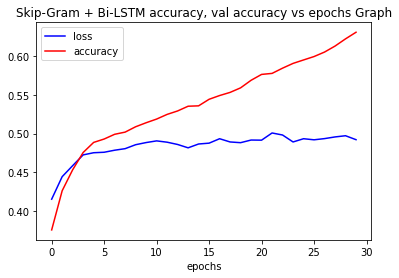

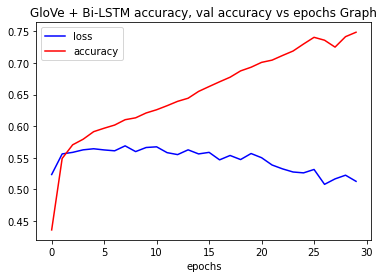

In [29]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_sg_bi.history['val_accuracy'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_glove_bi.history['val_accuracy'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()